<a href="https://colab.research.google.com/github/LiyaGaynutdinova/mlp_MNIST/blob/main/MLP_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

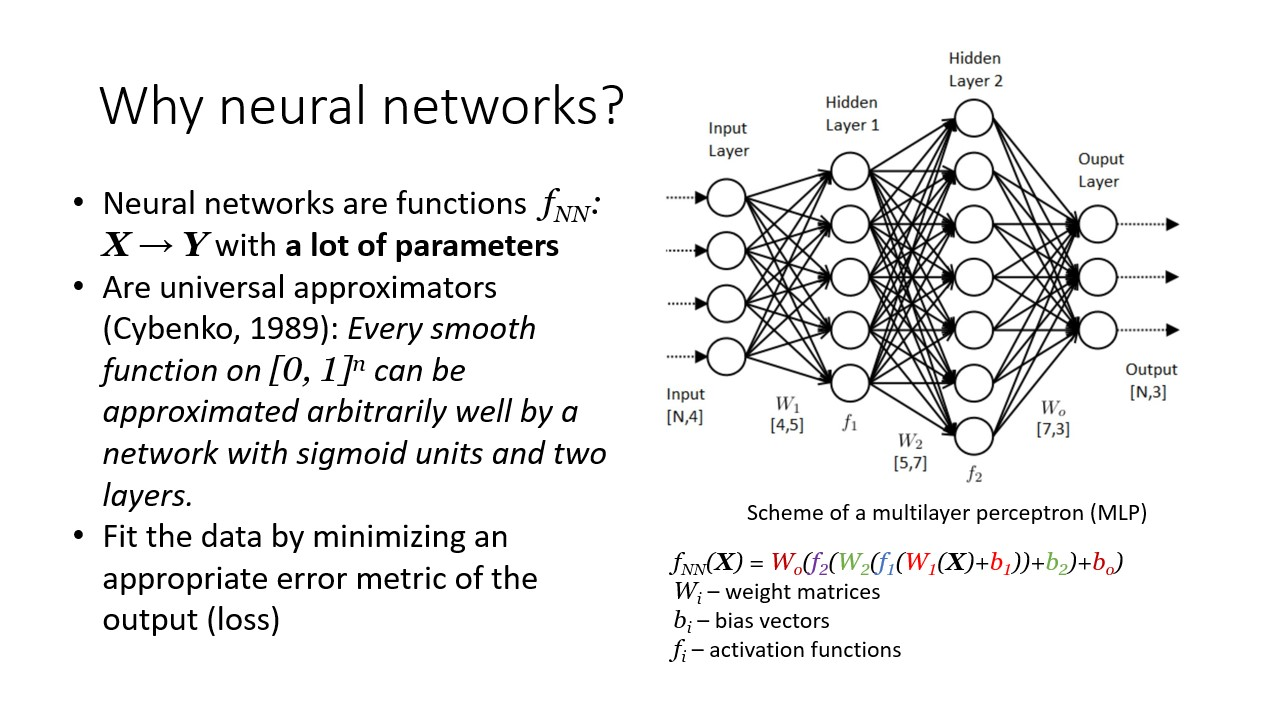
This is a demonstration of how to build, train, and use neural networks in PyTorch. We are going to build a simple fully connected neural network that classifies hand-written digits on the famous MNIST dataset.

If you're using this notebook on Colab, good news! You don't need to install any libraries. If you're working on a local machine, make sure you have Python 3 and these libraries installed:

*   Pytorch
*   Torchvision
*   Matplotlib
*   Numpy
*   Scikit-learn

You can install them by copying the line below into a code cell and executing it:

!pip install torch torchvision matplotlib numpy scikit-learn

Now we can import the libraries we need:

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

You can calculate matrix operations much faster if your machine has GPU. You can enable GPU acceleration in Colab by selecting Runtime -> Change runtime type -> Picking "GPU" from the drop-down menu.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Now we can build a new network. For that, we make a new instance of nn.Module class from the torch library.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        y = self.fc3(x)
        return torch.softmax(y, dim=1), x

net = Net().to(device)
print(net)

Now we need to prepare our dataset. The black-and-white images of the MNIST dataset can be downloaded with the torch library. Then we have to convert it to a tensor - a special array, that can store dependencies on other tensors, so the gradients can be computed automatically.

In [ ]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

We can look at the images from the dataset:

In [ ]:
plt.imshow(train_dataset.__getitem__(1)[0].squeeze(), cmap='gray_r')

Now we have to define the objective function: here we want to minimize the number of incorrectly labeled digits. The optimizer then takes care of the rest :)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

While training, we need to check on the error in the test dataset after each epoch, to make sure the model generalizes well.

In [ ]:
epochs = 10

train_losses = []
test_losses = []

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Training Loss: {running_loss / 100:.3f}, Training Accuracy: {100 * correct / total:.2f}%")
            train_losses.append(running_loss / 100)
            running_loss = 0.0
            correct = 0
            total = 0

    net.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch + 1}, Test Loss: {test_loss:.3f}, Test Accuracy: {100 * correct / total:.2f}%")


Now we can plot the training process.

In [ ]:
plt.plot(np.arange(1.1, 10.1, 0.1),train_losses, label='Training loss')
plt.plot(np.arange(1., 11.),test_losses, label='Test loss')
plt.legend()
plt.show()

You can probably see that the achieved accuracy is very high, but not a 100%. Let's look at the pictures that were labeled incorrectly.

In [ ]:
net.eval()
correct = 0
total = 0
test_loss = 0.0

incorrect_images = []
incorrect_labels = []
incorrect_preds = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                incorrect_images.append(inputs[i].cpu())
                incorrect_labels.append(labels[i].cpu())
                incorrect_preds.append(predicted[i].cpu())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {100 * correct / total:.2f}%")

fig = plt.figure(figsize=(11, 11))

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.axis('off')
    ax.set_title(f"True: {incorrect_labels[i]}, Predicted: {incorrect_preds[i]}")
    ax.imshow(incorrect_images[i].squeeze(), cmap='gray_r')

plt.show()

How does the model achieve this? We can see that our last hidden layer is a vector of 64 dimensions. Before assigning the probability of the digit belonging to a certain class, the networks separates this 64-dimensional space, so the images of the same digit are grouped together. It will be hard to visualize, so we can use [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project these clusters to the 2d space.

In [ ]:
from sklearn.manifold import TSNE

net.eval()
hidden_activations = []
labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, batch_labels = data
        inputs = inputs.to(device)

        # Get the activations of the last hidden layer
        _, h = net(inputs)
        hidden_activations.append(h.cpu().detach().numpy())
        labels.append(batch_labels)

hidden_activations = np.concatenate(hidden_activations)
labels = np.concatenate(labels)

# Use t-SNE to reduce the dimensionality of the activations to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
tsne_embeddings = tsne.fit_transform(hidden_activations)

# Plot the t-SNE embeddings colored by their true labels
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='tab10')
legend = ax.legend(*scatter.legend_elements(), title="Labels")
ax.add_artist(legend)
plt.show()